# Tensorflow Introduction

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

2023-01-09 11:56:54.161063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-09 11:56:54.161079: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# check tensorflow version
tf.__version__

'2.9.0'

### Basic Optimization with GradientTape

- `GradientTape` makes using tensorflow simpler. We only need to implement forward propagation through a computational graph and the derivatives will be computed by tensorflow.
- `tf.Tensor` are equivalents of numpy arrays.
- `tf.Variables` define variables.

In [3]:
# read datasets
train_dataset = h5py.File('datasets/train_signs.h5', "r")
test_dataset = h5py.File('datasets/test_signs.h5', "r")

In [4]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

2023-01-09 11:56:55.391910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 11:56:55.392209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-09 11:56:55.392240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-09 11:56:55.392265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-09 11:56:55.392289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

*Warnings appear because I'm not using the GPU for now.*

In [5]:
type(x_train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [6]:
# inspect shape and dtype
print(y_train.element_spec)

TensorSpec(shape=(), dtype=tf.int64, name=None)


To access the content of tensorflow datasets we need to iterate over them.

In [7]:
# creating a python iterator with iter
print(next(iter(x_train)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


In [8]:
# creating a loop
for element in x_train:
    print(element)
    break

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


To transform tensorflow arrays we need to invoke the `map` method and pass a function as an argument.

In [9]:
def normalize(image):
    """
    Transform an image into a tensor of shape (64 * 64 * 3, 1)
    and normalize its components.
    
    Arguments
    image - Tensor.
    
    Returns: 
    result -- Transformed tensor 
    """
    image = tf.cast(image, tf.float32) / 256.0
    image = tf.reshape(image, [-1,1])
    return image

In [10]:
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

In [11]:
new_train.element_spec

TensorSpec(shape=(12288, 1), dtype=tf.float32, name=None)

In [12]:
print(next(iter(new_train)))

tf.Tensor(
[[0.88671875]
 [0.859375  ]
 [0.8359375 ]
 ...
 [0.8125    ]
 [0.81640625]
 [0.81640625]], shape=(12288, 1), dtype=float32)


**Linear function**

We'll compute $WX + B$ where $W$, $X$ and $b$ are drawn from a random normal distribution.

In [13]:
def linear_function():
    """
    Implements a linear function: 
            Initializes X to be a random tensor of shape (3,1)
            Initializes W to be a random tensor of shape (4,3)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- Y = WX + b 
    """

    np.random.seed(1)

    X = tf.constant(np.random.randn(3,1), name = 'X')
    W = tf.Variable(np.random.randn(4,3), name = 'W')
    b = tf.Variable(np.random.randn(4,1), name = 'b')
    Y = tf.add(tf.matmul(W, X), b)

    return Y


In [14]:
# testing the function
result = linear_function()
print(result)

assert type(result) == EagerTensor, "Use the TensorFlow API"
assert np.allclose(result, [[-2.15657382], [ 2.95891446], [-1.08926781], [-0.84538042]]), "Error"
print("\033[92mAll test passed")

tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)
All test passed


**Sigmoid function**

`tf.keras.activations.sigmoid` requires `float16`, `float32`, `float64`, `complex64`, or `complex128`

In [15]:
def sigmoid(z):
    
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    a -- (tf.float32) the sigmoid of z
    """

    z = tf.cast(z, tf.float32)
    a = tf.keras.activations.sigmoid(z)

    return a

In [16]:
# testing the function
result = sigmoid(-1)
print ("type: " + str(type(result)))
print ("dtype: " + str(result.dtype))
print ("sigmoid(-1) = " + str(result))
print ("sigmoid(0) = " + str(sigmoid(0.0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

def sigmoid_test(target):
    result = target(0)
    assert(type(result) == EagerTensor)
    assert (result.dtype == tf.float32)
    assert sigmoid(0) == 0.5, "Error"
    assert sigmoid(-1) == 0.26894143, "Error"
    assert sigmoid(12) == 0.99999386, "Error"

    print("\033[92mAll test passed")

sigmoid_test(sigmoid)

type: <class 'tensorflow.python.framework.ops.EagerTensor'>
dtype: <dtype: 'float32'>
sigmoid(-1) = tf.Tensor(0.26894143, shape=(), dtype=float32)
sigmoid(0) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(12) = tf.Tensor(0.99999386, shape=(), dtype=float32)
All test passed


**One hot encodings**

Convert categorical variables into a set of columns with values 0 or 1.

In [17]:
def one_hot_matrix(label, depth=6):
    """
    Computes the one hot encoding for a single label
    
    Arguments:
        label --  (int) Categorical labels
        depth --  (int) Number of different classes that label can take

    Returns:
         one_hot -- tf.Tensor A single-column matrix with the one hot encoding.
    """

    one_hot = tf.one_hot(label, depth, axis=0)
    one_hot = tf.reshape(one_hot, (depth, 1))

    return one_hot

In [18]:
# testing the function
def one_hot_matrix_test(target):
    label = tf.constant(1)
    depth = 4
    result = target(label, depth)
    print(result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert result.shape[1] == 1, f"Reshape to have only 1 column"
    assert np.allclose(result,  [[0.], [1.], [0.], [0.]] ), "Wrong output. Use tf.one_hot"
    result = target(3, depth)
    assert np.allclose(result, [[0.], [0.], [0.], [1.]] ), "Wrong output. Use tf.one_hot"
    
    print("\033[92mAll test passed")

one_hot_matrix_test(one_hot_matrix)


tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]], shape=(4, 1), dtype=float32)
All test passed


In [19]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [20]:
print(next(iter(new_y_test)))

tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(6, 1), dtype=float32)


**Initialize the parameters**

`tf.keras.initializers.GlorotNormal` draws samples from a truncated normal distribution centered in 0, with $stddev = \sqrt{\frac{2}{fan_{in} + fan_{out}}}$ where $fan_{in}$ is the number of input units and $fan_{out}$ is the number of output units, both in the weight tensor.

In [21]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)

    W1 = tf.Variable(initializer(shape=(25,12288)))
    b1 = tf.Variable(initializer(shape=(25,1)))
    W2 = tf.Variable(initializer(shape=(12,25)))
    b2 = tf.Variable(initializer(shape=(12,1)))
    W3 = tf.Variable(initializer(shape=(6, 12)))
    b3 = tf.Variable(initializer(shape=(6,1)))

    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2,
        'W3': W3,
        'b3': b3
    }

    return parameters

In [22]:
# testing the function
def initialize_parameters_test(target):
    parameters = target()

    values = {"W1": (25, 12288),
              "b1": (25, 1),
              "W2": (12, 25),
              "b2": (12, 1),
              "W3": (6, 12),
              "b3": (6, 1)}

    for key in parameters:
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        assert type(parameters[key]) == ResourceVariable, "All parameter must be created using tf.Variable"
        assert tuple(parameters[key].shape) == values[key], f"{key}: wrong shape"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5,  f"{key}: Use the GlorotNormal initializer"
        assert np.std(parameters[key].numpy()) > 0 and np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    print("\033[92mAll test passed")
    
initialize_parameters_test(initialize_parameters)

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
All test passed


In [23]:
parameters = initialize_parameters()

### Building a Neural Network in Tensorflow

**Implementing forward propagation**

`@tf.function` is a tensorflow decorator that builds a computational graph to execute the function. [More info](https://www.tensorflow.org/guide/function).

In [24]:
@tf.function
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # compute forward propagation
    Z1 = tf.math.add(tf.linalg.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3, A2), b3)
    
    return Z3

In [25]:
# testing the function
def forward_propagation_test(target, examples):
    for batch in examples:
        forward_pass = target(batch, parameters)
        assert type(forward_pass) == EagerTensor, "Your output is not a tensor"
        assert forward_pass.shape == (6, 1), "Last layer must use W3 and b3"
        assert np.any(forward_pass < 0), "Don't use a ReLu layer at end of your network"
        assert np.allclose(forward_pass, 
                           [[-1.6999884],
                           [0.6465866],
                           [1.0545614],
                           [-1.446655],
                           [-0.6424109],
                           [1.4200424]]), "Output does not match"
        print(forward_pass)
        break
    

    print("\033[92mAll test passed")

forward_propagation_test(forward_propagation, new_train)

tf.Tensor(
[[-1.6999884]
 [ 0.6465866]
 [ 1.0545614]
 [-1.446655 ]
 [-0.6424109]
 [ 1.4200424]], shape=(6, 1), dtype=float32)
All test passed


**Compute the cost**

In [26]:
@tf.function
def compute_cost(logits, labels):
    """
    Computes the cost
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    labels -- "true" labels vector, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """

    cost = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true = labels, y_pred = logits, from_logits=True))

    return cost


In [27]:
# testing the function
def compute_cost_test(target):
    labels = np.array([[0., 1.], [0., 0.], [1., 0.]])
    logits = np.array([[0.6, 0.4], [0.4, 0.6], [0.4, 0.6]])
    result = compute_cost(logits, labels)
    print(result)
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    assert (np.abs(result - (0.7752516 +  0.9752516 + 0.7752516) / 3.0) < 1e-7), "Test does not match. Did you get the mean of your cost functions?"

    print("\033[92mAll test passed")

compute_cost_test(compute_cost)

tf.Tensor(0.8419182681095858, shape=(), dtype=float64)
All test passed


**Train the model**

In [28]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []

    # initialize parameters
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # define batch size
    X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8) 
    Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8)

    # training loop
    for epoch in range(num_epochs):

      epoch_cost = 0

      for (minibatch_X, minibatch_Y) in zip(X_train, Y_train):
            with tf.GradientTape() as tape:
                  Z3 = forward_propagation(minibatch_X, parameters)
                  minibatch_cost = compute_cost(Z3, minibatch_Y)

            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += (minibatch_cost / minibatch_size)

      if print_cost == True and epoch % 10 == 0:
            print(f'Cost after epoch {epoch}: {epoch_cost}')
      if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iteration (per fives)')
    plt.title(f'learning rate = {learning_rate}')
    plt.show()

    # save the parameters
    print('Parameters have been trained!')
    
    return parameters

Cost after epoch 0: 2.6728713512420654
Cost after epoch 10: 2.5963432788848877
Cost after epoch 20: 2.5314979553222656
Cost after epoch 30: 2.4715051651000977
Cost after epoch 40: 2.4159281253814697
Cost after epoch 50: 2.3644211292266846
Cost after epoch 60: 2.31671142578125
Cost after epoch 70: 2.2725794315338135
Cost after epoch 80: 2.231842041015625
Cost after epoch 90: 2.1943368911743164
Cost after epoch 100: 2.1599137783050537
Cost after epoch 110: 2.1284284591674805
Cost after epoch 120: 2.099738359451294
Cost after epoch 130: 2.073702573776245
Cost after epoch 140: 2.050175428390503
Cost after epoch 150: 2.0290141105651855
Cost after epoch 160: 2.0100696086883545
Cost after epoch 170: 1.9931944608688354
Cost after epoch 180: 1.9782382249832153
Cost after epoch 190: 1.965051293373108
Cost after epoch 200: 1.9534845352172852
Cost after epoch 210: 1.9433914422988892
Cost after epoch 220: 1.934629201889038
Cost after epoch 230: 1.9270609617233276
Cost after epoch 240: 1.92055571079

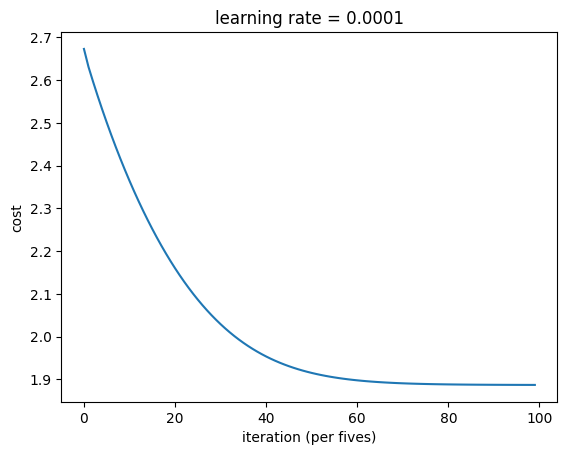

Parameters have been trained!


{'W1': <tf.Variable 'Variable:0' shape=(25, 12288) dtype=float32, numpy=
 array([[-0.02126303,  0.0039984 , -0.01407152, ...,  0.00256899,
          0.00416768, -0.01197838],
        [-0.00306418,  0.0054086 , -0.00568262, ..., -0.00307007,
         -0.00444062,  0.01600167],
        [ 0.01130269, -0.00020176, -0.00461518, ...,  0.0048945 ,
         -0.00351967,  0.01075348],
        ...,
        [ 0.00905831, -0.01937189, -0.00437705, ..., -0.01060717,
         -0.01325075,  0.00897861],
        [ 0.01761359,  0.01275828, -0.00208231, ..., -0.01735994,
         -0.01134041,  0.00496331],
        [-0.00755536, -0.00654506,  0.00766105, ...,  0.02646794,
          0.00744555, -0.0284807 ]], dtype=float32)>,
 'b1': <tf.Variable 'Variable:0' shape=(25, 1) dtype=float32, numpy=
 array([[-0.05235177],
        [-0.03777683],
        [-0.37215972],
        [ 0.11882801],
        [ 0.42583638],
        [-0.0046337 ],
        [-0.03730996],
        [-0.03547631],
        [-0.14370558],
        

In [29]:
model(new_train, new_y_train, new_test, new_y_test, num_epochs=500, minibatch_size=16)